<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/SCAREDUnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#Installation

In [57]:
!pip -q install torchmetrics


     |████████████████████████████████| 529 kB 7.5 MB/s 


#Download Data

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8'
#url = "https://drive.google.com/file/d/1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8/view?usp=share_link"
gdown.download(url,'SCARED.zip',quiet=True) 
import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 

In [45]:
path_ = path_depth[0][:-14] + 'Image.png'
path_.replace('left', 'Left')

'SCARED/d3k2_Left_Image.png'

#Prepare Dataloader

torch.Size([3, 256, 320]) torch.Size([1, 256, 320]) tensor(0.0588) tensor(0.8863)


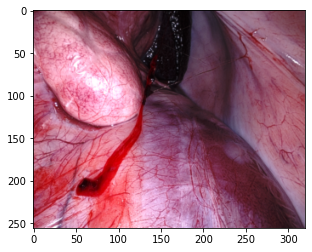

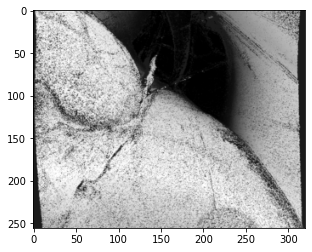

In [66]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        depth = tifffile.imread(self.path_depth[i])[:,:,2]
        depth = np.nan_to_num(depth, posinf=0, neginf=0)
        depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
        depth = Image.fromarray(depth).convert('L')
        path_ = self.path_depth[i]
        path_ = path_.replace('left', 'Left')
        path_ = path_.replace('right', 'Right')
        img = Image.open(path_[:-14] + 'Image.png').convert('RGB')
        if self.transform:
            img, depth = self.transform(img), self.transform(depth)

        return img, depth

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_depth_all = glob('SCARED/*.tiff')
path_depth_train = path_depth_all[:42]
path_depth_valid = path_depth_all[42:]

dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
dataset_valid = MyDataset(path_depth=path_depth_train, transform=transform_all)
plt.figure(), plt.imshow(dataset_train[0][0].permute(1,2,0))
plt.figure(), plt.imshow(dataset_train[0][1][0], cmap='gray')
print(dataset_train[0][0].shape, dataset_train[0][1].shape, dataset_train[0][1].min(), dataset_train[0][1].max())


train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)



#Arguments

In [55]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=20, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#Training

In [62]:
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from PIL import Image
import os


import math
import torch.nn.functional as F
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)

def train(model, trainloader, optimizer, criterion):
    model.train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        outputs = model(image_batch)
        loss = criterion(outputs, label_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            outputs = model(image_batch)
            #outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
        return np.mean(mse_all), np.mean(ssim_all)

def main():
    seed_everything()
    args = get_args()

    path_depth_all = glob('SCARED/*.tiff')
    path_depth_train = path_depth_all[:42]
    path_depth_valid = path_depth_all[42:]

    dataset_train = MyDataset(path_depth=path_depth_train, transform=transform_all)
    dataset_valid = MyDataset(path_depth=path_depth_valid, transform=transform_all)

    train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=2)
    valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=2)

    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
            in_channels=3, out_channels=1, init_features=32, pretrained=False)
    model.to(device)

    args.criterion = 'bce'

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)

    
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    criterion = nn.BCELoss().to(device)
    best_mse, best_ssim, best_epoch = np.inf, 0, 0
    for epoch_num in range(args.max_epochs):
        train(model, train_loader, optimizer, criterion)
        mse, ssim = test(model, valid_loader)
        if mse < best_mse:
            best_mse = mse
            best_ssim = ssim
            best_epoch = epoch_num
            torch.save(model.state_dict(), args.ckpt)
            
        print('Epoch:{}, Curr MSE(L2):{:.6f}, Best MSE(L2):{:.6f}, Best SSIM:{:.6f}, Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, best_mse, best_ssim, best_epoch, args.criterion, optimizer.param_groups[0]['lr']))

if __name__ == "__main__":
    main()

Sample size- Train:42, Valid: 6


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


Epoch:0, Curr MSE(L2):0.058328, Best MSE(L2):0.058328, Best SSIM:0.340456, Best Epoch:0, Criterion:bce, Lr:0.001
Epoch:1, Curr MSE(L2):0.058377, Best MSE(L2):0.058328, Best SSIM:0.340456, Best Epoch:0, Criterion:bce, Lr:0.001
Epoch:2, Curr MSE(L2):0.058355, Best MSE(L2):0.058328, Best SSIM:0.340456, Best Epoch:0, Criterion:bce, Lr:0.001
Epoch:3, Curr MSE(L2):0.058319, Best MSE(L2):0.058319, Best SSIM:0.340399, Best Epoch:3, Criterion:bce, Lr:0.001
Epoch:4, Curr MSE(L2):0.058272, Best MSE(L2):0.058272, Best SSIM:0.340527, Best Epoch:4, Criterion:bce, Lr:0.001
Epoch:5, Curr MSE(L2):0.058238, Best MSE(L2):0.058238, Best SSIM:0.340615, Best Epoch:5, Criterion:bce, Lr:0.001
Epoch:6, Curr MSE(L2):0.058293, Best MSE(L2):0.058238, Best SSIM:0.340615, Best Epoch:5, Criterion:bce, Lr:0.001
Epoch:7, Curr MSE(L2):0.058376, Best MSE(L2):0.058238, Best SSIM:0.340615, Best Epoch:5, Criterion:bce, Lr:0.001
Epoch:8, Curr MSE(L2):0.059076, Best MSE(L2):0.058238, Best SSIM:0.340615, Best Epoch:5, Criteri

#Delete

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data):
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, i):
    depth = keep_image_size_open_tiff(self.data["depth"][i],(32,32))# ,(1280,1280) if enough RAM
    image = keep_image_size_open_rgb(self.data["image"][i],(32,32))
    return transform(image), torch.Tensor(np.array(depth)) #np.array(image), np.array(depth)


##read data

In [11]:
import gdown
url = 'https://drive.google.com/uc?id=1WFQr1gJdZamb22uGqu-7UoBz0hfeWuL9'
#url = "https://drive.google.com/file/d/1WFQr1gJdZamb22uGqu-7UoBz0hfeWuL9/view?usp=sharing
gdown.download(url,'rectified27.zip',quiet=True) 
import os
if not os.path.exists('/content/rectified27/'):
  !unzip -q rectified27.zip 

(288, 720, 3) (288, 720)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f85b6e9eb10>)

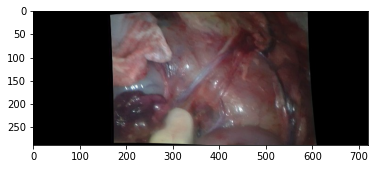

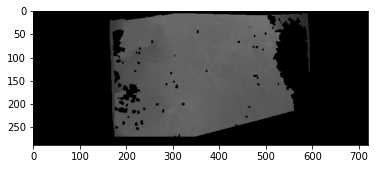

In [17]:
from PIL import Image
import numpy as np
img = Image.open('rectified27/image01/0000000142.jpg')
depth = Image.open('rectified27/depth01/0000000142.png')

print(np.array(img).shape, np.array(depth).shape)
plt.figure(), plt.imshow(img)
plt.figure(), plt.imshow(depth)

(256, 320, 4) (256, 320) 16 204


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f85a065e250>)

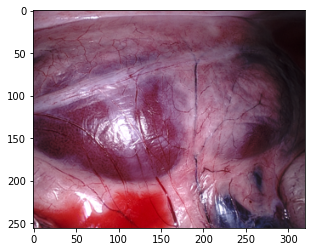

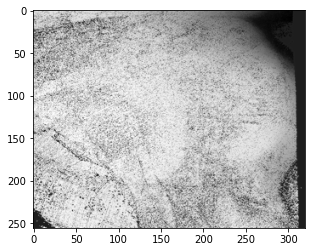

In [65]:
from PIL import Image
import numpy as np
import tifffile


size = (320, 256)
img = Image.open('SCARED/d1k1_Left_Image.png')
depth = tifffile.imread('SCARED/d1k1_left_depth_map.tiff')[:,:,2]
depth = np.nan_to_num(depth, posinf=0, neginf=0)
depth = cv2.applyColorMap(cv2.convertScaleAbs(depth, alpha=2.5), cv2.COLORMAP_JET)
depth = Image.fromarray(depth)

img = img.resize(size)
depth = depth.resize(size).convert('L')

# temp = max(colorimg.size)
# tiff = Image.new('RGB', (temp, temp))#'P' if grayscale
# tiff.paste(colorimg, (0, 0))

print(np.array(img).shape, np.array(depth).shape, np.array(depth).min(), np.array(depth).max())
plt.figure(), plt.imshow(img)
plt.figure(), plt.imshow(depth, cmap='gray')

#320 × 256 pixels.

In [1]:
import gdown
url = 'https://drive.google.com/uc?id=1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8'
#url = "https://drive.google.com/file/d/1mVumZGRmJ0ZybH1IITGQ-q_M0xvvqvw8/view?usp=share_link"
gdown.download(url,'SCARED.zip',quiet=True) 
import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q SCARED.zip 

In [ ]:

rm SCARED.zip

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive') 
sys.path.append('/content/drive/') 

import os
if not os.path.exists('/content/SCARED/'):
  !unzip -q /content/drive/MyDrive/SCARED.zip 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#https://stackoverflow.com/questions/7569553/working-with-tiffs-import-export-in-python-using-numpy

import os.path
from os import path
import pandas as pd

# gtpath = "/content/GT/"
# if path.exists(gtpath) == False:
#   os.mkdir(gtpath)

path = "/content/SCARED/"
filelist = []
for root, dirs, files in os.walk(path):
  for file in files:
#         filelist.append(os.path.join(root, file))   #cancatenate folder name with file name
    filelist.append(file)
filelist.sort()
data = {
    "image": [x for x in filelist if x.endswith(".png")],
    "depth": [x for x in filelist if x.endswith(".tiff")]
}
print("dataset size: ", len(data["image"]), len(data["depth"]))
df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=1)#A random 100% sample, reproducible 1
train = df[:42].reset_index(drop="true")#avoid old index is added as a column, only replace old index with new sequential index is used
valid = df[42:].reset_index(drop="true")
print("table of file names of validation set : \n",valid)
#print(valid.at[0,"depth"], valid["depth"][0])  #the same

dataset size:  48 48
table of file names of validation set : 
                   image                      depth
0  d2k1_Right_Image.png  d2k1_right_depth_map.tiff
1  d1k5_Right_Image.png  d1k5_right_depth_map.tiff
2   d1k5_Left_Image.png   d1k5_left_depth_map.tiff
3   d2k2_Left_Image.png   d2k2_left_depth_map.tiff
4  d5k2_Right_Image.png  d5k2_right_depth_map.tiff
5  d4k4_Right_Image.png  d4k4_right_depth_map.tiff


##prepare dataset

48 42 6


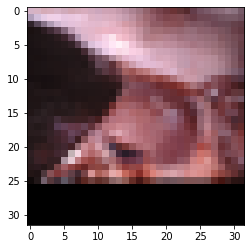

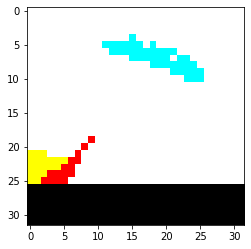

In [9]:
#https://github.com/qiaofengsheng/pytorch-UNet/blob/e9d2ec1f6f7c9336093e71e62b68c1adf5ecdbe0/data.py#L14
from PIL import Image
import tifffile
import numpy as np
import cv2

DIR = "/content/SCARED/"
def keep_image_size_open(path, size=(128, 128)):
    img = Image.open(path)
    temp = max(img.size)
    mask = Image.new('P', (temp, temp))
    mask.paste(img, (0, 0))
    mask = mask.resize(size)
    return mask
def keep_image_size_open_tiff(path, size=(128, 128)):
    img = tifffile.imread(DIR + path)[:,:,2]
    img = np.nan_to_num(img, posinf=0, neginf=0)
    colorimg = cv2.applyColorMap(cv2.convertScaleAbs(img, alpha=2.5), cv2.COLORMAP_JET)
    colorimg = Image.fromarray(colorimg)
    temp = max(colorimg.size)
    tiff = Image.new('RGB', (temp, temp))#'P' if grayscale
    tiff.paste(colorimg, (0, 0))
    tiff = tiff.resize(size)
    return tiff
def keep_image_size_open_rgb(path, size=(128, 128)):
    img = Image.open(DIR + path)
    temp = max(img.size)
    image = Image.new('RGB', (temp, temp))
    image.paste(img, (0, 0))
    image = image.resize(size)
    return image

print(len(df),len(train), len(valid))
keep_image_size_open_rgb(train["image"][4]) # ,(1280,1280) if enough RAM
square_tiff = keep_image_size_open_tiff(train["depth"][4] )
#torch.Tensor(np.array(square_tiff))


import os
import numpy as np
import torch
from torch.utils.data import Dataset
#from utils import *
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

class MyDataset(Dataset):
  def __init__(self, data):
      self.data = data

  def __len__(self):
      return len(self.data)

  def __getitem__(self, i):
    depth = keep_image_size_open_tiff(self.data["depth"][i],(32,32))# ,(1280,1280) if enough RAM
    image = keep_image_size_open_rgb(self.data["image"][i],(32,32))
    return transform(image), torch.Tensor(np.array(depth)) #np.array(image), np.array(depth)


from torch.nn.functional import one_hot
d = MyDataset(train)
plt.figure(0)
plt.imshow(d[0][0].permute(1,2,0))
plt.figure(1)
plt.imshow(d[0][1])

# print(d[0][0].shape)
# print(np.transpose(d[0][0],(1,2,0)).shape)
# print(d[0][1].shape)
# print(d[0][1].long().shape)

# print(one_hot(d[0][1].long()).shape)

# if d[0][0].shape == (3, 1280, 1280):
#   d[0][0] = np.transpose(d[0][0],(1,2,0))
#   print("transposed!")
# plt.figure(figsize=(15,9))
# plt.subplot(121)
# plt.imshow(d[0][0])
# plt.subplot(122)
# plt.imshow(d[0][1])
# plt.show()

In [10]:
d[0][1].shape

torch.Size([32, 32, 3])

##net

In [ ]:
#https://zhuanlan.zhihu.com/p/467623152
#https://github.com/milesial/Pytorch-UNet
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        out_channels = [4,8,16,32,64]
        #out_channels = [16,32,64,128,256]
        #out_channels = [40,80,160,320,640]
        #out_channels = [64,128,256,512,1024]
        #out_channels = [80,160,320,640,1280]
        self.inc = DoubleConv(n_channels, out_channels[0])
        self.down1 = Down(out_channels[0], out_channels[1])
        self.down2 = Down(out_channels[1], out_channels[2])
        self.down3 = Down(out_channels[2], out_channels[3])
        self.down4 = Down(out_channels[3], out_channels[4])
        self.up1 = Up(out_channels[4], out_channels[3])
        self.up2 = Up(out_channels[3], out_channels[2])
        self.up3 = Up(out_channels[2], out_channels[1])
        self.up4 = Up(out_channels[1], out_channels[0])
        self.outc = OutConv(out_channels[0], n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

##training

In [ ]:
import os
import tqdm
from torch import nn, optim
import torch
from torch.utils.data import DataLoader
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weight_path = 'params/unet.pth'
# data_path = r'data'
save_path = 'train_image'


num_classes = 1
data_loader = DataLoader(MyDataset(train), batch_size=1, shuffle=True)
net = UNet(3,num_classes).to(device)
# if os.path.exists(weight_path):
#   net.load_state_dict(torch.load(weight_path))
#   print('successful load weight！')
# else:
#   print('not successful load weight')


from torchmetrics import StructuralSimilarityIndexMeasure
def ssim(preds, target):
  ssim_loss = StructuralSimilarityIndexMeasure().to(device)(preds, target)
  ssim_loss = torch.mean(1 - ssim_loss)
  return ssim_loss

opt = optim.Adam(net.parameters())
#loss_fun = nn.CrossEntropyLoss()#ssim()


epoch = 1
while epoch < 10:
  for i, (image, depth) in enumerate(tqdm.tqdm(data_loader)):
    depth = np.transpose(depth, (0,3,1,2))#[:,2,:,:]# depth = torch.squeeze(np.transpose(depth, (0,3,1,2), 1)
    image, depth = image.to(device), depth.to(device)#torch.Size([1, 3, 1280, 1280])
    #logits Vs Probability
    #Probability = torch.sigmoid(logits)
    logits = net(image)   #expected input[1, 1280, 1280, 3] to have 3 channels
    probability = torch.sigmoid(logits)
    #print(image.shape, pred.shape, depth.long().shape)
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 1280, 1280, 3])
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 3, 1280, 1280]) depth transposed
    #torch.Size([1, 3, 1280, 1280]) torch.Size([1, 1, 1280, 1280]) torch.Size([1, 1280, 1280]) depth transposed and second dim droped
    train_loss = loss_fun = ssim(probability, depth.long().type(torch.float32))#Expected input batch_size (1) to match target batch_size (3).
    # input pre:(Class), (Nbatch, Class) or (N,C,d_1,d_2,...)
    # target depth:(), (Nbatch,) or (N,d_1,d_2,...)
    opt.zero_grad()
    train_loss.backward()
    opt.step()
    if i % 20 == 0:
        print(f'{epoch}-{i}-train_loss===>>{train_loss.item()}')
  # if epoch % 10 == 0:
  #   torch.save(net.state_dict(), weight_path)
  #   print('save successfully!')
  epoch += 1

In [ ]:
# import random
# import torch
# import time
# import numpy as np
# import torch.optim as optim
# import collections
# import torch.nn as nn

# #test example
# input, target = next(iter(SCAREDDataset(data=valid, batch_size=2)))
# plt.figure(figsize=(15,9))
# for i, j in enumerate([0,3]):
#   plt.subplot(231+j)
#   plt.imshow((input[i] / 255))
#   plt.subplot(232+j)
#   plt.imshow(target[i])
#   plt.subplot(233+j)
#   plt.imshow(cv2.applyColorMap(cv2.convertScaleAbs(target[i], alpha=7.4), cv2.COLORMAP_JET))
# # fig, ax = plt.subplots(2, 2, figsize=(150, 150))
# # for i in range(2):
# #   ax[i, 0].imshow((input[i]))
# #   ax[i, 1].imshow((target[i]), cmap=plt.cm.jet.set_bad(color="black"))

# # dataloaders = {
# #   'train':  SCAREDDataset(data=train, batch_size=2),
# #   'val': SCAREDDataset(data=valid, batch_size=2)
# # }
# # images, depthmaps = dataloaders["val"]
# # for image in images:
# #   image = np.transpose(image,(0,3,1,2))

# # for images, depthmaps in dataloaders['val']:
# #   #for image in images:#(2, 1024, 1280, 3)# channels-last
# #     images = np.transpose(images,(0,3,1,2))

# training_set = SCAREDDataset(data=train, batch_size=2)
# training_iter = iter(SCAREDDataset(data=train, batch_size=2))
# batch = next(training_iter)
# images, depthmaps = batch
# print(training_set, training_iter)  #SCAREDDataset #Iteraotr
# #print(batch)#tuple 4d array
# print(images.shape, depthmaps.shape)#array  #(2, 1024, 1280, 3) (2, 1024, 1280, 3)
# print(images[0].shape)#(1024, 1280, 3)


# #training_set, validation_set = next(iter(SCAREDDataset(data=train, batch_size=2))), next(iter(SCAREDDataset(data=valid, batch_size=2)))
# model  = UNet(3, 1)#first in_channel, n_classes  
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# loss = nn.CrossEntropyLoss()


# final_losses=[]
# t_start = time.time()
# for i in range(3):
#   model.train(mode=True)
#   batch = next(training_iter) 
#   images, depthmaps = batch
#   images = np.transpose(images,(0,3,1,2))
#   depthmaps = np.transpose(depthmaps, (0,3,1,2))
#   print(depthmaps.shape)#(2, 3, 1024, 1280)
#   pred = model(images)
#   loss = loss(pred, depthmaps)
#   final_losses.apend(loss)
#   print("epoch: {}  loss: {}".format(i,loss.item()))
#   optimizer.zero_grad()
#   loss.backward() 
#   optimizer.step()



In [ ]:
# a = np.ones(5)
# b = a.copy()
# print(a)
# for i, j in enumerate([4,5]):
#   a[i,] = j
#   b[i] = j
#   print(i,j)

#   print(a,b,a==b)

In [ ]:
# import numpy as np

# x = np.array([[[0], [1], [2]]])
# print(x.shape,
# np.squeeze(x, axis=-1).shape,
# np.squeeze(x, axis=-1))

# i = np.empty((2, *(1,2), 3))#4D numpy array
# d = np.empty((2, *(1,2), 1))
# print(d)


In [ ]:
# import tensorflow as tf

# # The inputs are 1024x1280 RGB images with 3 `channels_last` and the batch size is 2.
# batch_size = 2
# in_channel = 3
# height, width = 1024, 1280
# out_channel = 320
# kernal_size = 3
# input_shape = (batch_size, height, width, in_channel)#batch size, height, width, channel
# x = tf.random.normal(input_shape)

# y = tf.keras.layers.Conv2D(out_channel, kernal_size, padding="same")(x)# With strides=(1, 1), `padding` as "same".no activation
# print(y.shape)  #(2, 1024, 1280, 320)

# y = tf.keras.layers.MaxPool2D(strides=(2, 2))(x)# strides=(2, 2)
# print(y.shape)  #(2, 512, 640, 3)

In [ ]:
# import torch.nn as nn
# import torch

# # The inputs are 1024x1280 RGB images with 3 `channels_first` and the batch size is 2.
# batch_size = 2
# in_channel = 3
# height, width = 1024, 1280
# out_channel = 320
# kernal_size = 3
# input_size = (batch_size, in_channel, height, width) #batch size, channels_first, height, width
# x = torch.randn(input_size)#x = torch.normal(2, 3, input_shape)#mean, std, size 

# m = nn.Conv2d(in_channel, out_channel, kernal_size, padding=1)(x)# square kernels and with padding
# print(m.shape)#torch.Size([2, 320, 1024, 1280])

# m = nn.MaxPool2d(batch_size)(x)# square kernels and with padding default stride=batch_size
# print(m.shape)#torch.Size([2, 3, 512, 640])

In [ ]:
# def get_config():
#   return dict(
#       net = 'unet',
#       encoder = dict(),
#       data = 'scared', 
#       net_config = dict(),
#       training=dict(
#             batch_size=12,
#             learning_rate=1e-4,
#             epochs=3,
#             mode='pair',
#             loss='ssim',  # other: hamming
#             n_training_steps=500000),  # control time
#       evaluation=dict(batch_size=2),
#       seed = 8
#   )
# config = get_config()
# for (k, v) in config.items():
#   print("{} = {}".format(k, v))#print("%s = %s" % (k, v))#print(f"{k} = {v}")

In [ ]:
seed = config['seed']
random.seed(seed)
np.random.seed(seed + 1)
torch.manual_seed(seed + 2)

In [ ]:
# import tifffile
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np

# print("image shape: {}  depth shape: {}".format(cv2.imread(path + df.at[37,"image"]).shape, 
#                                                  tifffile.imread(path + df.at[43,"depth"]).shape))
# #WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
# image_example1 = cv2.imread(path + df.at[37,"image"])
# image_example2 = cv2.imread(path + df.at[43,"image"])
# depth_example = tifffile.imread(path + df.at[43,"depth"])[:,:,2].astype(np.float32) * 256.0
# depth_example2 = tifffile.imread(path + df.at[43,"depth"]).squeeze().astype(np.float32) 
# colored_depth_example = cv2.applyColorMap(cv2.convertScaleAbs(depth_example, alpha=0.015), cv2.COLORMAP_JET)
# colored_depth_example2 = cv2.applyColorMap(cv2.convertScaleAbs(depth_example2, alpha=7.4), cv2.COLORMAP_JET)
# print("image shape: {}  depth shape: {} / {}".format(image_example1.shape, depth_example.shape, depth_example2.shape))
# plt.figure(figsize=(15,9))
# for i in range(0,6,3):
#   plt.subplot(231+i)
#   plt.imshow(image_example2)
#   #plt.imshow(depth_example2)
#   plt.subplot(232+i)
#   plt.imshow(colored_depth_example)
#   plt.subplot(233+i)
#   plt.imshow(colored_depth_example2)

In [ ]:
# import tifffile
# import numpy as np
# from torch.utils.data import Dataset
# import cv2

# HEIGHT = 1024
# WIDTH = 1280

# class SCAREDDataset(Dataset):
#   def __init__(self, data, batch_size, dim=(HEIGHT,WIDTH), shuffle=True):
#     self.data = data
#     self.batch_size = batch_size
#     self.dim = dim
#     self.id = np.arange(len(data["image"]))

#   def __len__(self):
#     return int(len(self.data))//self.batch_size

#   def __getitem__(self, index):
#     #TODO: if (index+1) > len(data)
#     idx = self.id[index*self.batch_size : (index+1)*self.batch_size]
#     batch = [self.id[i] for i in idx]
#     image, depth = self.generation(batch)
#     return image, depth

#   def generation(self, batch):
#     image = np.empty((self.batch_size, *self.dim, 3))
#     depth = np.empty((self.batch_size, *self.dim, 3))
#     for i, j in enumerate(batch):
#       image[i] = cv2.imread(path+self.data.at[j,"image"])
#       depth[i] = tifffile.imread(path+self.data.at[j,"depth"]).astype(np.float32).squeeze()#or [:,:,2]
#     return image, depth  
#     #TODO: flip = np.random.choicec([True, False])

# #test example
# batch_index = 2 #start from 0
# batch_size = 2
# id = np.arange(len(valid["image"]))
# idx = id[batch_index*batch_size : (batch_index+1)*batch_size]
# batch = [id[i] for i in idx]
# image = np.empty((batch_size, *(1024,1280), 3))
# depth = np.empty((batch_size, *(1024,1280), 3))
# for i, j in enumerate(batch):  #batch:[4, 5] list #idx:[4 5] numpy array
#   image[i] = cv2.imread(path+valid["image"][j])
#   depth[i] = tifffile.imread(path+valid["depth"][j]).astype(np.float32).squeeze()
# print(image.shape, depth.shape)
# plt.imshow(image[0])